# Tutorial 7c - Freeform Surfaces

### September 2024

This tutorial demonstrates how freeform surfaces can be modeled in Optiland. Several freeform types are supported, including polynomial and Chebyshev surfaces.

In this tutorial, we will design a unique singlet lens with the following properties:

- rays from on-axis field point intersect the image plane at y=3mm
- RMS spot size is minimized

This is rather unique (and perhaps not all that useful), as rays from the on-axis field point in a standard lens are generally centered on the optical axis.

In [1]:
import numpy as np

from optiland import analysis, optic, optimization

Preparation:

We start by defining a freeform lens class, which has a freeform as its first surface.

The freeform surface is defined as:

$z(x, y) = \frac{r^2}{R \cdot (1 + \sqrt{(1 - (1 + k) \cdot r^2 / R^2)})} + \sum\limits_{i}\sum\limits_{j}{C_{i, j} \cdot x^i \cdot y^j}$

where

- $x$ and $y$ are the local surface coordinates
- $r^2 = x^2 + y^2$
- $R$ is the radius of curvature
- $k$ is the conic constant
- $C_{i, j}$ is the polynomial coefficient for indices $i, j$

In [2]:
class Freeform(optic.Optic):
    def __init__(self):
        super().__init__()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)

        # ======== Add polynomial freeform here =====================================
        self.add_surface(
            index=1,
            radius=100,
            thickness=5,
            surface_type="polynomial",  # <-- surface_type='polynomial'
            is_stop=True,
            material="SF11",
            coefficients=[],
        )
        # ===========================================================================

        self.add_surface(index=2, thickness=100)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=25)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

We simply need to specify the surface type as 'polynomial' to make the first surface a freeform. Note that we did not pass coefficients to the surface, which implies all coefficients will be zero.

Let's generate and view the starting point lens, which will simply be spherical, as the freeform coefficients are all zero.

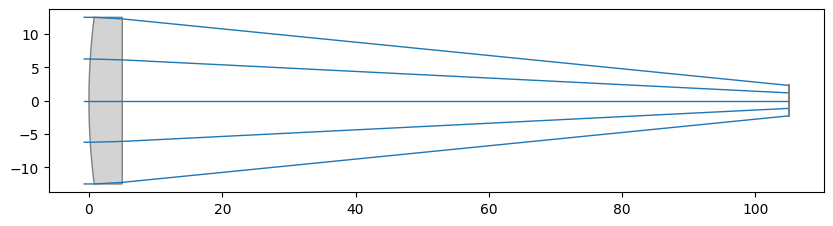

In [3]:
lens = Freeform()
lens.draw(num_rays=5)

We now define the optimization problem. Let's start with the two operands: 1) RMS spot size and 2) real ray y-intercept.

In [4]:
problem = optimization.OptimizationProblem()

# RMS spot size operand
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "wavelength": 0.55,
    "num_rays": 5,
}
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

# Real y-intercept operand
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "Px": 0,
    "Py": 0,
    "wavelength": 0.55,
}
problem.add_operand(
    operand_type="real_y_intercept",
    target=3,
    weight=1,
    input_data=input_data,
)  # <-- target=3

We will include the first 9 polynomial coefficients of our surface as variables. We will not add bounds for the coefficients.

In [5]:
for i in range(3):
    for j in range(3):
        problem.add_variable(
            lens,
            "polynomial_coeff",
            surface_number=1,
            coeff_index=(i, j),
        )

problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                12.1244 |                 0 |
+----+------------------------+-------------------+
+----+------------------+----------+----------+---------+----------+--------------------+
|    | Operand Type     |   Target |   Weight |   Value |    Delta |   Contribution (%) |
|----+------------------+----------+----------+---------+----------+--------------------|
|  0 | rms spot size    |        0 |        1 | 1.76759 |  1.76759 |            25.7694 |
|  1 | real y intercept |        3 |        1 | 0       | -3       |            74.2306 |
+----+------------------+----------+----------+---------+----------+--------------------+
+----+------------------+-----------+---------+--------------+--------------+
|    | Variable Type    |   Surface |   Value | Min. Bound   | Max. Bound   |
|----+------------------+-----------+-------

Let's optimize and observe the merit function improvement.

In [6]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

In [7]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |            0.000131601 |           99.9989 |
+----+------------------------+-------------------+
+----+------------------+----------+----------+-----------+-------------+--------------------+
|    | Operand Type     |   Target |   Weight |     Value |       Delta |   Contribution (%) |
|----+------------------+----------+----------+-----------+-------------+--------------------|
|  0 | rms spot size    |        0 |        1 | 0.0114717 | 0.0114717   |      100           |
|  1 | real y intercept |        3 |        1 | 3.00001   | 7.39774e-06 |        4.15852e-05 |
+----+------------------+----------+----------+-----------+-------------+--------------------+
+----+------------------+-----------+--------------+--------------+--------------+
|    | Variable Type    |   Surface |        Value | Min. Bound   | Max. Bound   |
|---

Finally, we plot the lens and view a spot diagram.

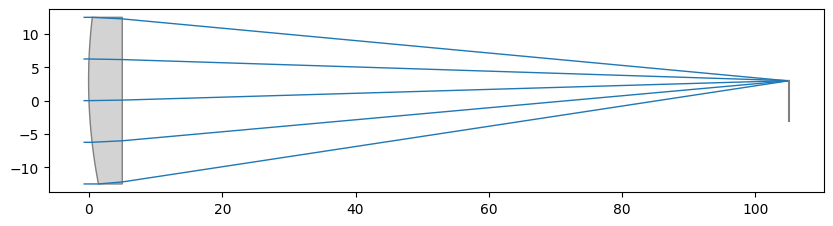

In [8]:
lens.draw(num_rays=5)

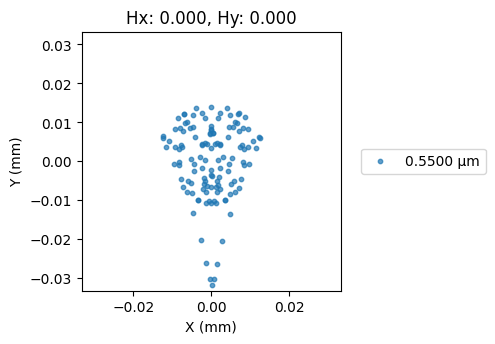

In [9]:
spot = analysis.SpotDiagram(lens)
spot.view()

We clearly see that the front surface of our lens appears to be tilted, which forces the on-axis rays to intercept the image plane near y=3mm.

Conclusions:

- We introduced freeform surfaces in Optiland.
- We optimized a singlet lens for minimal spot size and for an off-axis real ray intercept point.
- Additional freeform surfaces are available and can be found in the optiland.geometries module or the documentation.